In [117]:
%matplotlib inline 


In [119]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

from matplotlib import pyplot as plt



In [86]:

import common.workshop as workshop
workshop.download_art_generation()
DATA_DIR='art'


File art/obj1-cat.jpg is already downloaded.
File art/obj2-dog.jpg is already downloaded.
File art/style1-van-gogh.jpg is already downloaded.
File art/style2-dali.jpg is already downloaded.


In [87]:
!ls ./art

obj1-cat.jpg  obj2-dog.jpg  style1-van-gogh.jpg  style2-dali.jpg


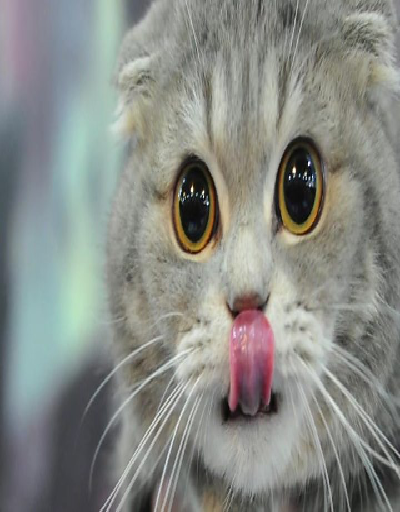

In [224]:
height = 512
width = 400

content_image_path = DATA_DIR+"/obj1-cat.jpg"
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image


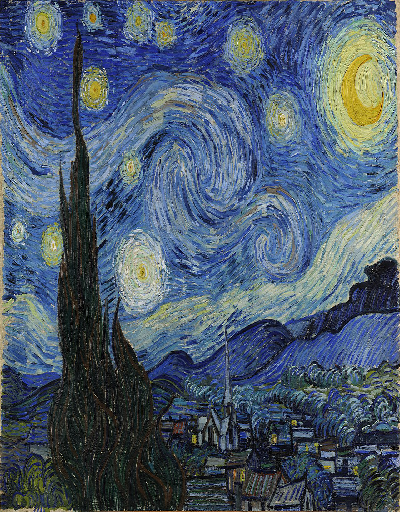

In [225]:
style_image_path = DATA_DIR+"/style1-van-gogh.jpg"
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image


In [226]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
# Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
# Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).
style_array = style_array[:, :, :, ::-1]



(1, 512, 400, 3)
(1, 512, 400, 3)


In [227]:

content_image_var = backend.variable(content_array)
style_image_var = backend.variable(style_array)
combination_image_var = backend.placeholder((1, height, width, 3))


In [228]:
combination_image_var

<tf.Tensor 'Placeholder_216:0' shape=(1, 512, 400, 3) dtype=float32>

In [229]:
input_tensor = backend.concatenate([content_image_var, style_image_var, combination_image_var], axis=0)


In [230]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)


In [231]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers


{'input_9': <tf.Tensor 'concat_8:0' shape=(3, 512, 400, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1_8/Relu:0' shape=(3, 512, 400, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_8/Relu:0' shape=(3, 512, 400, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_8/MaxPool:0' shape=(3, 256, 200, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_8/Relu:0' shape=(3, 256, 200, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_8/Relu:0' shape=(3, 256, 200, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_8/MaxPool:0' shape=(3, 128, 100, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_8/Relu:0' shape=(3, 128, 100, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_8/Relu:0' shape=(3, 128, 100, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_8/Relu:0' shape=(3, 128, 100, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_8/MaxPool:0' shape=(3, 64, 50, 256) dtype=float32

In [232]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0


In [233]:
loss = backend.variable(0.)


In [234]:
def content_loss(layers, layer_name, content_weight):
    layer = layers[layer_name]
    content_image_features = layer[0, :, :, :]
    combination_features = layer[2, :, :, :]
    return content_weight * backend.sum(backend.square(combination_features - content_image_features))

closs = content_loss(layers, 'block2_conv2', content_weight)

print(closs)


Tensor("mul_79:0", shape=(), dtype=float32)


In [235]:
def gram_matrix(x):
    print(x)
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    print(features)
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss_single_layer(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def style_loss(layers, feature_layers, style_weight):
    loss = backend.variable(0.)
    for layer_name in feature_layers:
        layer_features = layers[layer_name]
        style_features = layer_features[1,:,:,:]
        combination_features = layer_features[2,:,:,:]
        sl = style_loss_single_layer(style_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
    return loss

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

sloss = style_loss(layers, feature_layers, style_weight)


Tensor("strided_slice_334:0", shape=(512, 400, 64), dtype=float32)
Tensor("Reshape_130:0", shape=(64, 204800), dtype=float32)
Tensor("strided_slice_335:0", shape=(512, 400, 64), dtype=float32)
Tensor("Reshape_131:0", shape=(64, 204800), dtype=float32)
Tensor("strided_slice_338:0", shape=(256, 200, 128), dtype=float32)
Tensor("Reshape_132:0", shape=(128, 51200), dtype=float32)
Tensor("strided_slice_339:0", shape=(256, 200, 128), dtype=float32)
Tensor("Reshape_133:0", shape=(128, 51200), dtype=float32)
Tensor("strided_slice_342:0", shape=(128, 100, 256), dtype=float32)
Tensor("Reshape_134:0", shape=(256, 12800), dtype=float32)
Tensor("strided_slice_343:0", shape=(128, 100, 256), dtype=float32)
Tensor("Reshape_135:0", shape=(256, 12800), dtype=float32)
Tensor("strided_slice_346:0", shape=(64, 50, 512), dtype=float32)
Tensor("Reshape_136:0", shape=(512, 3200), dtype=float32)
Tensor("strided_slice_347:0", shape=(64, 50, 512), dtype=float32)
Tensor("Reshape_137:0", shape=(512, 3200), dtype=f

In [236]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

total_var_loss = total_variation_weight * total_variation_loss(combination_image_var)


In [237]:
loss = sloss + closs + total_var_loss
grads = backend.gradients(loss, combination_image_var)


In [238]:
grads

[<tf.Tensor 'gradients_12/AddN_15:0' shape=(1, 512, 400, 3) dtype=float32>]

In [239]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image_var], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()


In [240]:

def to_img(vector, height, width):
    img = np.copy(vector.reshape((height, width, 3)))
    img = img[:, :, ::-1]
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = np.clip(img, 0, 255).astype('uint8')
    return img

def show_img(img):
    plt.imshow(img)
    plt.show()
    
# show_img(to_img(x, height, width))
# show_img(to_img(x, height, width))


# Image.fromarray(x).show()


Start of iteration 0
Current loss value: 55497130000.0
Iteration 0 completed in 13s


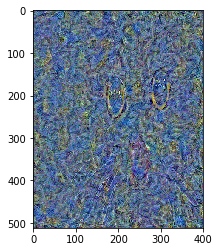

Start of iteration 1
Current loss value: 35772637000.0
Iteration 1 completed in 12s


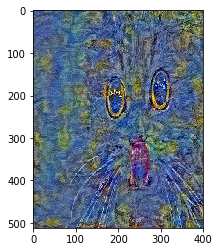

Start of iteration 2
Current loss value: 29341622000.0
Iteration 2 completed in 12s


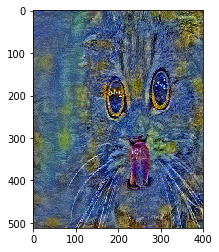

Start of iteration 3
Current loss value: 27177273000.0
Iteration 3 completed in 12s


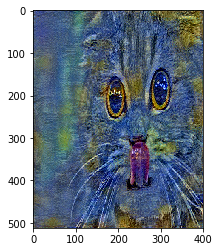

Start of iteration 4
Current loss value: 26345116000.0
Iteration 4 completed in 12s


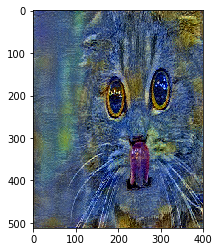

Start of iteration 5
Current loss value: 25879372000.0
Iteration 5 completed in 12s


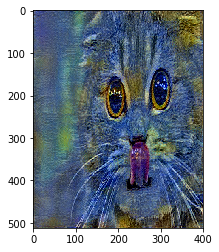

Start of iteration 6
Current loss value: 25540243000.0
Iteration 6 completed in 12s


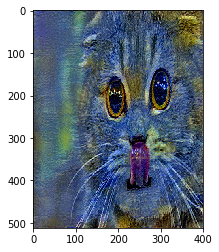

Start of iteration 7
Current loss value: 25319078000.0
Iteration 7 completed in 12s


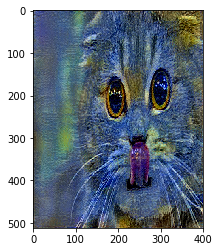

Start of iteration 8
Current loss value: 25144345000.0
Iteration 8 completed in 12s


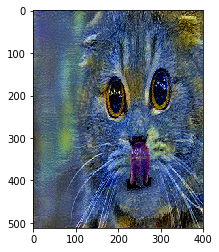

Start of iteration 9
Current loss value: 25019240000.0
Iteration 9 completed in 12s


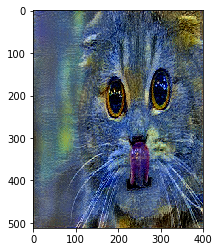

In [241]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    
    show_img(to_img(x, height, width))
    